In [1]:
#loading the dataframe

import pandas as pd
df = pd.read_csv('/kaggle/input/dcsass-dataset/DCSASS Dataset/Labels/Shoplifting.csv')
df

,Shoplifting001_x264_0,Shoplifting,0
0,Shoplifting001_x264_1,Shoplifting,0
1,Shoplifting001_x264_2,Shoplifting,0
2,Shoplifting001_x264_3,Shoplifting,0
3,Shoplifting001_x264_4,Shoplifting,0
4,Shoplifting001_x264_5,Shoplifting,0
...,...,...,...
890,Shoplifting054_x264_27,Shoplifting,0
891,Shoplifting054_x264_28,Shoplifting,0
892,Shoplifting054_x264_29,Shoplifting,0
893,Shoplifting054_x264_30,Shoplifting,0


In [2]:
df['Shoplifting001_x264_0'] = df['Shoplifting001_x264_0'] + ".mp4"
df

,Shoplifting001_x264_0,Shoplifting,0
0,Shoplifting001_x264_1.mp4,Shoplifting,0
1,Shoplifting001_x264_2.mp4,Shoplifting,0
2,Shoplifting001_x264_3.mp4,Shoplifting,0
3,Shoplifting001_x264_4.mp4,Shoplifting,0
4,Shoplifting001_x264_5.mp4,Shoplifting,0
...,...,...,...
890,Shoplifting054_x264_27.mp4,Shoplifting,0
891,Shoplifting054_x264_28.mp4,Shoplifting,0
892,Shoplifting054_x264_29.mp4,Shoplifting,0
893,Shoplifting054_x264_30.mp4,Shoplifting,0


In [3]:
# making directory to store the temporary data which will be used later

import os

os.mkdir('/kaggle/working/data')
os.mkdir('/kaggle/working/data/0')
os.mkdir('/kaggle/working/data/1')

In [4]:
# here we can see that the videos are of 4 seconds each so using 3d convolutions would be useless we would have to process the data on individual frames
# also some videos are of less than 4 seconds and padding 1 second video to 4 second would not make any sense

import cv2
video = cv2.VideoCapture('/kaggle/input/dcsass-dataset/DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_1.mp4')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))


print(f"Video Resolution: {width}x{height}")
print(f"Video FPS: {fps}")
print(f"Total Frames: {total_frames}")

Video Resolution: 320x240
Video FPS: 30.0
Total Frames: 120


In [5]:
# saving the individual frames into two folders 0 and 1 in the working directory of kaggle and making sure that the labels of 0 class are almost equal to the 1 class of data

frame_num = 1
zero_cnt = 0
one_cnt = 0
for i in range(len(df)):
    path = df["Shoplifting001_x264_0"].iloc[i]
    path = "/kaggle/input/dcsass-dataset/DCSASS Dataset/Shoplifting/" + path[:19] +".mp4/" +path
    video = cv2.VideoCapture(path)
    label = df["0"].iloc[i]
    ret,frame = video.read()
    frame_cnt = 1
    while ret:
        if frame_cnt%30==0:
            if label == 1:
                cv2.imwrite(f'/kaggle/working/data/{label}/f{frame_num}.jpg',frame)
                one_cnt+=1
            else:
                if zero_cnt<one_cnt or one_cnt<100:
                    cv2.imwrite(f'/kaggle/working/data/{label}/f{frame_num}.jpg',frame)
                    zero_cnt+=1
            frame_num+=1
        frame_cnt+=1
        ret,frame = video.read()

<h1>Now we make data generator so that we can use images stored in the directories to train ml Model</h1>


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root_dir = '/kaggle/working/data'
datagen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(320, 240),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(320,240),
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    subset='validation'
)


2024-04-19 15:51:56.528573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 15:51:56.528666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 15:51:56.678483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 727 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


In [7]:
# making ml model to do binary classification here we do transfer learning on imagenet model

from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32

base_model = keras.applications.MobileNetV2(include_top=False, input_shape=(320, 240,3))


    
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


checkpoint_path = "/kaggle/working/model.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode='max')

# # Compile the model
model.compile(optimizer=Nadam(weight_decay=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)

/tmp/ipykernel_34/3723797294.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(include_top=False, input_shape=(320, 240,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# training the model

epochs = 10
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks = [reduce_lr,checkpoint_callback]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/23 ━━━━━━━━━━━━━━━━━━━━ 26:29 72s/step - accuracy: 0.3750 - loss: 0.8600

I0000 00:00:1713542000.975995    3700 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7391 - loss: 0.4947
Epoch 1: val_accuracy improved from -inf to 0.63536, saving model to /kaggle/working/model.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7428 - loss: 0.4903 - val_accuracy: 0.6354 - val_loss: 1.1347 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9187 - loss: 0.2148
Epoch 2: val_accuracy did not improve from 0.63536
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9193 - loss: 0.2139 - val_accuracy: 0.6354 - val_loss: 0.8442 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9703 - loss: 0.0820
Epoch 3: val_accuracy improved from 0.63536 to 0.64641, saving model to /kaggle/working/model.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.9696 - loss: 0.0845 - val_accuracy: 0.6464 - val_loss: 0.9616 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9216 - los

<h1>here we can see that the best performance of the model was 90 percent and we saved it's weights automatically and then the model just started to overfit and the accuracy decreases drastically</h1>

In [9]:
# loading the best weihts of the model
model.load_weights('/kaggle/working/model.weights.h5')

<h1>Evaluating the model</h1>

In [10]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, top_k_accuracy_score, confusion_matrix
import numpy as np
from keras.models import load_model


# # Evaluate the model on the validation set
predictions = model.predict(val_generator)


# Convert true labels to class labels
true_labels = val_generator.classes
predictions  = predictions >0.5
predictions = predictions.astype(int)
predictions = predictions.flatten()
# # Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels,predictions)

# # Calculate recall, F1 score, and classification report
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
conf_matrix = confusion_matrix(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions)


print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 658ms/step
Overall Accuracy: 90.61%
Recall: 90.61%
F1 Score: 90.67%
[[104  11]
 [  6  60]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       115
           1       0.85      0.91      0.88        66

    accuracy                           0.91       181
   macro avg       0.90      0.91      0.90       181
weighted avg       0.91      0.91      0.91       181



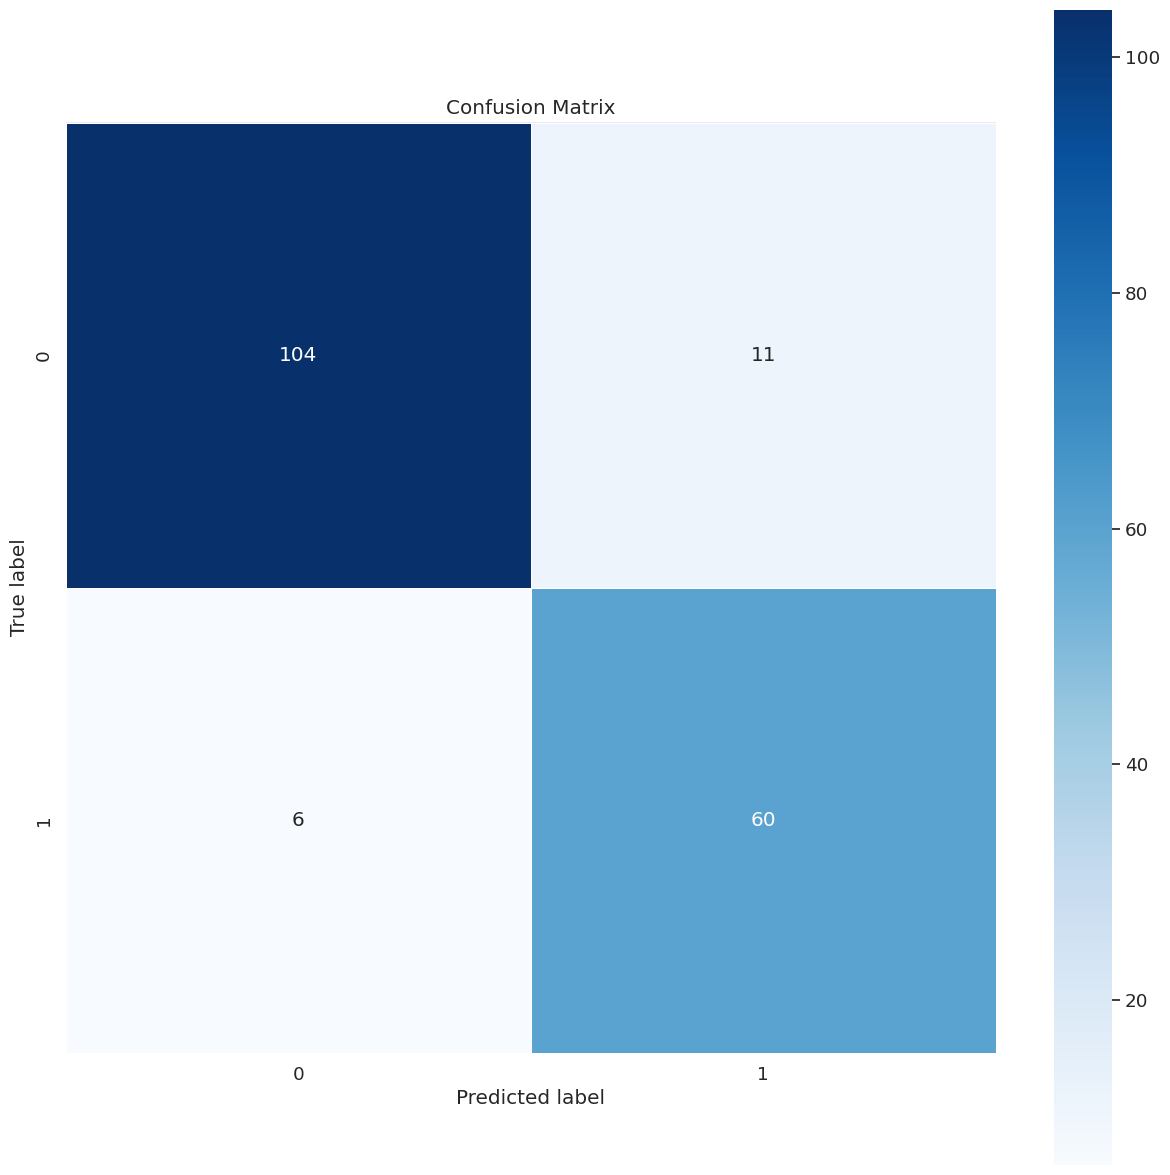

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15,15))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, linewidths=.5, square=True,)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels

plot_confusion_matrix(true_labels,predictions)